In [4]:
import numpy as np
import pandas as pd
import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

In [5]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [6]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

Other indicators of cardiogenic shock: 
+ MVO2 < 60 (mixed venous oxygen saturation), obtained from the PA catheter
+ CVO2 < 60 (central venous oxygen saturation0, obtained from the PA catheter or the central venous catheter
+ Caradiac index (CI) < 2.2, obtained from the PA catheter
+ Cardiac catheterization within 25 hours of ICU admission
+ Mechanical support in place: intraaortic balloon pump, impella, LVAD
+ Being on inotropes (milrinone, dobutamine)

In [15]:
query = \
"""
SELECT * FROM d_items
WHERE label ~* '.*mvo2.*' OR
label ~* '.*cvo2.*' OR
label ~* '.*saturation.*'
"""
res = pd.read_sql_query(query, con)
res

,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
0,146,143,CvO2,None,carevue,chartevents,None,None,None,None
1,3450,2265,MVO2,None,carevue,chartevents,None,None,None,None
2,3649,2574,MVO2 SAT,None,carevue,chartevents,None,None,None,None
3,4449,6947,mvo2,None,carevue,chartevents,None,None,None,None
4,14638,226860,RA %O2 Saturation (PA Line),RA %O2 Saturation (PA Line),metavision,chartevents,PA Line Insertion,%,Numeric,None
5,14639,226861,ART %O2 saturation (PA Line),ART %O2 saturation (PA Line),metavision,chartevents,PA Line Insertion,%,Numeric,None
6,14640,226862,PA %O2 Saturation (PA Line),PA %O2 Saturation (PA Line),metavision,chartevents,PA Line Insertion,%,Numeric,None
7,14641,226863,PVR %O2 Saturation (PA Line),PVR %O2 Saturation (PA Line),metavision,chartevents,PA Line Insertion,dynes*sec/cm5,Numeric,None
8,14642,226865,SVR %O2 Saturation (PA Line),SVR %O2 Saturation (PA Line),metavision,chartevents,PA Line Insertion,dynes*sec/cm5,Numeric,None
9,14787,227542,ScvO2 (Presep) Calibrated,ScvO2 (Presep) Calibrated,metavision,datetimeevents,Hemodynamics,None,Date time,None


In [17]:
query = \
"""
SELECT * FROM d_items
WHERE label ~* '.*cardiac index.*'
"""
res = pd.read_sql_query(query, con)
res

,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
0,121,116,Cardiac Index,None,carevue,chartevents,None,None,None,None
1,4721,7610,cardiac index o,None,carevue,chartevents,None,None,None,None
2,15497,228368,Cardiac Index (CI NICOM),Cardiac Index (CI NICOM),metavision,chartevents,NICOM,L/min/m2,Numeric,None


This one was really easy to find. Again, use most proximal to echo? 

In [29]:
query = \
"""
SELECT ef.row_id, ef.subject_id, ef.hadm_id, ef.icustay_id, ce.itemid, ce.value
FROM chartevents ce
RIGHT JOIN echo_filtered ef
ON ce.icustay_id = ef.icustay_id
WHERE itemid in ('116', '7610', '228368')
"""
res = pd.read_sql_query(query, con)
res.head()

,row_id,subject_id,hadm_id,icustay_id,itemid,value
0,67805,36,182104,280987,116,3.0852000713348389
1,67805,36,182104,280987,116,2.0358700752258301
2,67805,36,182104,280987,116,3.4708499908447266
3,67805,36,182104,280987,116,2.1076200008392334
4,67805,36,182104,280987,116,2.7040400505065918


In [24]:
len(res['subject_id'].unique())

582

In [25]:
len(res.dropna()['subject_id'].unique())

575

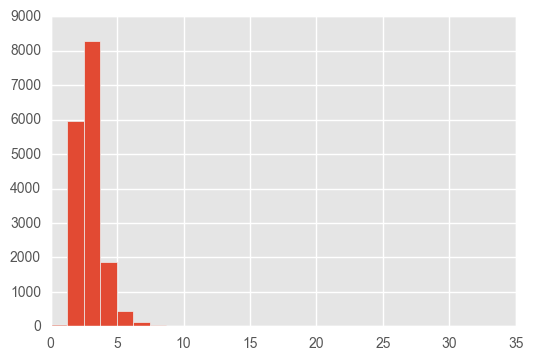

In [36]:
res['value'].astype(float).hist(bins = 25)

Which is a rough estimate of how many subjects have some CI index. 

In [21]:
query = \
"""
SELECT * FROM d_items
WHERE label ~* '.*cardiac cath.*' OR
label ~* '.*percutaneous coronary intervention.*' OR
label ~* '.*pci.*' OR
label ~* '.*coronary arteriography.*' OR
label ~* '.*coronary angiogram.*'
"""
res = pd.read_sql_query(query, con)
res

,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
0,6193,41627,pepcid gtt,None,carevue,inputevents_cv,Free Form Intake,None,None,None
1,13897,225430,Cardiac Cath,Cardiac Cath,metavision,procedureevents_mv,4-Procedures,None,Process,None
2,14060,225907,Famotidine (Pepcid),Famotidine (Pepcid),metavision,inputevents_mv,Medications,dose,Solution,None


In [22]:
query = \
"""
SELECT * FROM d_items
WHERE label ~* '.*intraaortic.*' OR
label ~* '.*iabp.*' OR
label ~* '.*impella.*' OR
label ~* '.*lvad.*'
"""
res = pd.read_sql_query(query, con)
res

,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
0,222,224,IABP Mean,None,carevue,chartevents,None,None,None,None
1,223,225,IABP setting,None,carevue,chartevents,None,None,None,None
2,396,429,LVAD Flow LPM,None,carevue,chartevents,None,None,None,None
3,2030,5938,lvad svr,None,carevue,chartevents,None,None,None,None
4,3607,2512,SILVADENE FEET BID,None,carevue,chartevents,None,None,None,None
5,3609,2515,IABP-BP,None,carevue,chartevents,None,None,None,None
6,3838,2865,iabp-bp,None,carevue,chartevents,None,None,None,None
7,4197,6424,IABP BP,None,carevue,chartevents,None,None,None,None
8,15336,228148,ABI Ankle BP R (Impella),ABI Ankle BP R (Impella),metavision,chartevents,Impella,mmHg,Numeric,None
9,15337,228149,ABI Brachial BP L (Impella),ABI Brachial BP L (Impella),metavision,chartevents,Impella,mmHg,Numeric,None
